# Second Chances at Austin Animal Shelters<a class="tocSkip">

# Project Goals <a class="tocSkip">
- Discover drivers that influences a dog's outcome
- Utilize the drives in machine learning models to predict the outcome
- Obtain a deeper understanding of how drivers influence outcome to develop a next steps plan to improve upon the model

# Executive Summary<a class="tocSkip">

**Questions:**

    1. Does a dog's breed influence their chances at finding a new home?
    2. Does a dog's color influence their chances at finding a new home?
    3. Does their age influence their chances at finding a new home?
    4. Does their time in a shelter affect their desirability to potential adoptive parents?
**Takeaways:**
   - All four features proved to be drivers of influence. There were some values that stood out.
   - Pit Bulls are adopted and returnd at a higher rate.
   - Black and white dogs are adopted at a higher rate.
   - Age slightly influences adoption, but has a increased influence for them being returned to their owner.
   - Majority of dogs are adopted or returned to their owner within the first 30 days.
    

    
    

# Imports<a class="tocSkip">

In [1]:
import pandas as pd
import numpy as np
import os
import env
import acquire as a
import prepare as p
import visual as viz
from sklearn.model_selection import train_test_split

#Stats imports & evaluations
from scipy import stats
from scipy.stats import pearsonr, spearmanr, ttest_1samp, ttest_ind
import math
from sklearn.metrics import accuracy_score

#visual imports
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# modeling method
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings("ignore")

# Acquire Data<a class="tocSkip">

- Data acquired from data.austintexas.gov. 
    - Intakes data set: 148,133 rows
    - Outcomes data set: 148,339 rows 
- Each row represents a dog
- Each column represents the dogs features and background information

In [2]:
# Acquire data sets
intakes = a.get_aac_intakes()
outcomes = a.get_aac_outcomes()

# Prepare<a class="tocSkip">

- Renamed columns to be user friendly.
- Merged intake and outcome data sets.
- Dropped nulls.
- Coverted date columns to datetime data types.
- Subset data set for dogs.
    - top 10 dog breeds
    - top 10 colors 
- Subset outcomes types for: 
    - adoption
    - return to owner
    - euthanasia
    - died
- Dropped columns:
    - found location
    - outcome subtype
    - duplicated columns from merge: breed, animal type, color, monthyear
- Feature engineered new columns using existing data.
    - time in shelter
    - months in shelter
    - age in months upon outcome
    - age in years upon outcome
- Split data into three sets (56/24/20):
    - train
    - validate 
    - test 

In [3]:
# Normalize columns. Drop outcome_subtype and name.
intake_df, outcome_df = p.prep_aac(intakes, outcomes)
# Merge intake and outcome data sets
combined = p.combined_df(intake_df, outcome_df)
# Covert date columns to datetime type. Subset for dogs. Top 10 breeds. Top 10 colors.
combined_dog = p.prep_combined(combined)
# Feature engineered columns. 
combined_dog = p.feature_eng(combined_dog)
# Split data 56/24/20. 
train, val, test= p.split_data(combined_dog,target='outcome_type')

# Data Dictionary<a class="tocSkip">

| Feature | Definition |
| :-- | :-- |
| animal_id | uniqe identifier for animal |
| date_intake | date of intake |
| intake_type | method in which animal was obtained |
| intake_condition | condition/reason for animal intake | 
| animal_type | type of animal |
| age_upon_intake | age of animal when obtained |
| date_outcome | date of outcome |
| date_of_birth | birth date |
| outcome_type | outcome of animal:<br> - adoption<br> - return to owner<br> - euthanasia<br> - died |
| sex_upon_outcome | sex of animal: <br> - intact<br> - neutered<br> - spayed|
| age_upon_outcome |age when outcome reached |
| breed | breed of animal |
| color | color(s) of animal |
| time_in_shelter | time spent in shelter in days |
| months_in_shelter | time spent in shelter in months |
| age_months_outcome | age of animal in months when outcome reached |
| age_years_outcome | age of animal in years when outcome reached |


# Glance into the Data<a class="tocSkip">

In [4]:
# dataframe
train.head()

,animal_id,date_intake,intake_type,intake_condition,animal_type,age_upon_intake,date_outcome,date_of_birth,outcome_type,sex_upon_outcome,age_upon_outcome,breed,color,time_in_shelter,months_in_shelter,age_months_outcome,age_years_outcome
182150,A796587,2019-06-03 12:24:00,Stray,Normal,Dog,1 year,2019-06-12 04:59:00,2018-06-03,Adoption,Neutered Male,1 year,Pit Bull,Blue/White,8,< 30 days,12.0,1 year
136196,A808871,2019-11-15 12:12:00,Stray,Normal,Dog,3 months,2019-11-19 05:10:00,2019-08-15,Adoption,Neutered Male,3 months,Chihuahua,Tan/White,3,< 30 days,3.0,1 year
103436,A847525,2021-12-03 12:31:00,Stray,Normal,Dog,2 months,2021-12-08 05:56:00,2021-09-12,Adoption,Spayed Female,2 months,Pit Bull,Tan,4,< 30 days,3.0,1 year
16445,A861991,2022-07-20 02:54:00,Owner Surrender,Normal,Dog,5 months,2022-08-16 06:42:00,2022-01-20,Adoption,Spayed Female,6 months,Pit Bull,Brown/White,27,< 30 days,7.0,1 year
81183,A718254,2015-12-26 11:54:00,Stray,Normal,Dog,1 year,2015-12-28 06:34:00,2014-12-26,Return to Owner,Neutered Male,1 year,Labrador Retriever,Black,1,< 30 days,12.0,1 year


# Explore<a class="tocSkip">

**Questions:**

   1. Does a dog's breed influence their chances at finding a new home?
   2. Does a dog's color influence their chances at finding a new home?
   3. Does their age influence their chances at finding a new home?
   4. Does their time in a shelter decrease their desirability to potential adoptive parents?

## Overall Outcomes<a class="tocSkip">

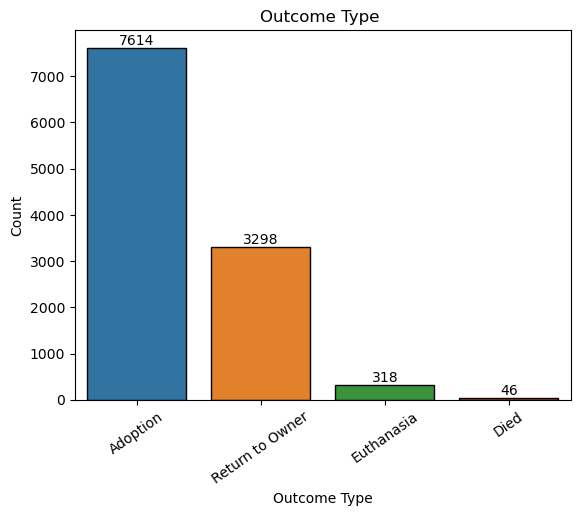

In [5]:
# Graph of outcomes
viz.overall_outcome(train)

<div class="alert alert-block alert-info">
<b>Takeaways:<br>
The majority of dogs are adopted or returned to their owner. A small amount of dogs are euthanized and a even smaller amount die within the shelter. 

# Q1. Does a dog's breed influence their chances at finding a new home?<a class="tocSkip">

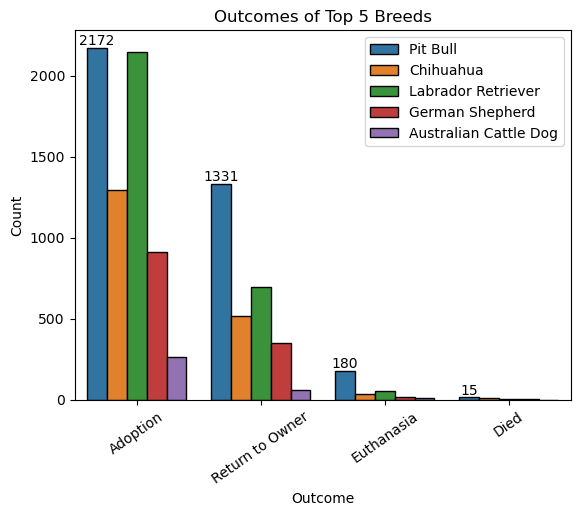

In [6]:
# Outcomes based on breed
viz.breed_plot(train)

<div class="alert alert-block alert-info">
<b>Takeaways:<br>
For the top five dogs, Pit Bulls are adopted the most, followed closely by Labrador Retrievers. Although, Pit Bulls also make up almost 25% of this data set. 
    


### Statistic Test<a class="tocSkip">

In [7]:
# Chi-Square Test
viz.chi_test(train,'breed','outcome_type')

Chi-Square Results
--------------------
P-value: 1.171973552787653e-43


## Q2. Does a dog's color influence their chances at finding a new home?<a class="tocSkip">

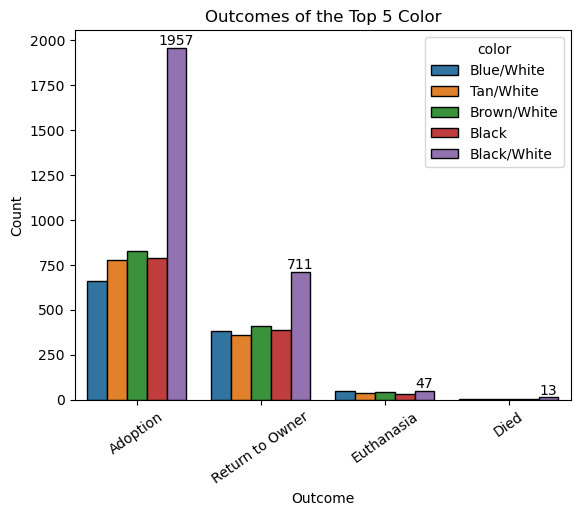

In [8]:
# Top 5 Color Visual
viz.color_plot(train)

<div class="alert alert-block alert-info">
<b>Takeaways:<br>
It seems that the majority of dogs that are either adopted or returned to their owner are black and white. The other four colors are relatively close to each other.
    

### Statistic Test<a class="tocSkip">

In [21]:
# Chi-Square Test
viz.chi_test(train,'color','outcome_type')

Chi-Square Results
--------------------
P-value: 1.7867971722261247e-12


## Q3. Does their age influence their chances at finding a new home?<a class="tocSkip">

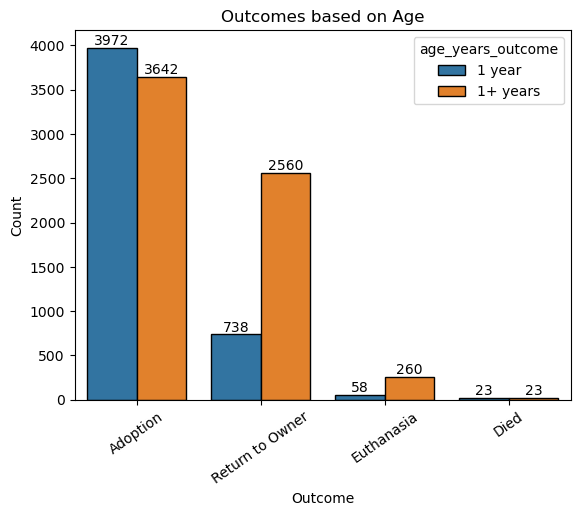

In [10]:
# Outcomes for Age
viz.age_plot(train)

<div class="alert alert-block alert-info">
<b>Takeaways:<br>
Age seems to have a small influence on whether they are adopted. As for being returned to owner, dogs that are a year old or younger get returned to their owner at a smaller rate than dogs over one year of age.
    

### Statistic Test<a class="tocSkip">

In [11]:
# T-test 1-sample
viz.ttest1samp1(train)

T-test Results
---------------
Test statistic: -17.37
P-value: 2.4258903869925795e-66


## Q4. Does their time in a shelter decrease their desirability to potential adoptive parents?<a class="tocSkip">

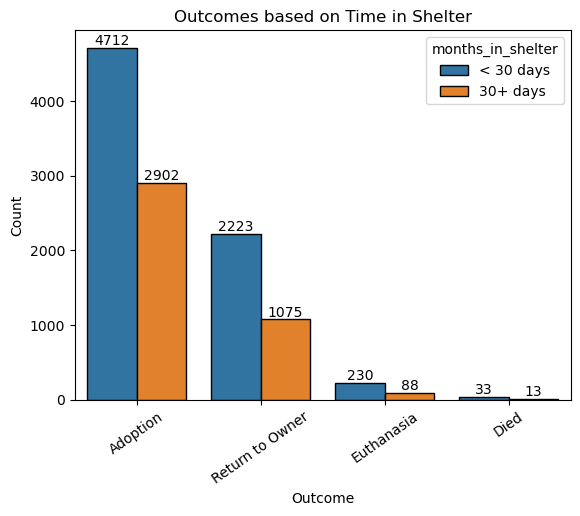

In [12]:
# Outcomes based on time in shelter
viz.time_plot(train)

<div class="alert alert-block alert-info">
<b>Takeaways:<br>
According to the graph, most dogs are adopted or returned to their owner within the first 30 days of arriving at the shelter. 
    

### Statistic Test<a class="tocSkip">

In [13]:
# Spearmans Test
viz.ttest1samp(train)

T-test Results
---------------
Test statistic: -7.75
P-value: 1.0253773659701435e-14


# Exploration Summary<a class="tocSkip">

<div class="alert alert-block alert-success">
<b> 
    In summary, all four features were found to be drivers of a outcome. Pit Bulls showed to be adopted and returned to their owners the most. Black and white dogs were adopted the most. Age did not seem to be a major factor when it came to adoption, but it was when it came to being returned to their owner. As for their time spent in the shelter, the majority of dogs are either adopted or returned to their owners within the first 30 days.
    

# Modeling<a class="tocSkip">

- Drivers moving forward: breed, age, color, and time in shelter
- Four models: 
    - Decision Tree
    - Random Forest
    - Logistic Regression 
    - K Nearest Neighbor

- Baseline is determined by the mode of outcome types. Adoption was the outcome for the majority of dogs. 
**Baseline: 67% ** 

In [14]:
# Create X and y trains
X_train, y_train, X_val, y_val, X_test, y_test = p.trains(train, val, test)
# Scale data
X_train, X_val, X_test = p.get_scaled(X_train, X_val, X_test)

## Decision Tree<a class="tocSkip">

In [15]:
# Decistion Tree
dec_tree = viz.dec_tree(X_train, y_train, X_val, y_val)

Results
---------
Train Accuracy: 0.7805
Validate Accuracy: 0.7761
Difference: 0.0044


## Random Forest<a class="tocSkip">

In [16]:
# Random Forest
rand_forest = viz.rand_forest(X_train, y_train, X_val, y_val)

Results
---------
Train Accuracy: 0.7772
Validate Accuracy: 0.7765
Difference: 0.0007


## Logistic Regression<a class="tocSkip">

In [17]:
# Logistic Regression
log_reg = viz.log_reg(X_train, y_train, X_val, y_val)

Results
---------
Train Accuracy: 0.7323
Validate Accuracy: 0.7321
Difference: 0.0002


## K Nearest Neighbor<a class="tocSkip">

In [18]:
# KNN
knn_df = viz.knn(X_train, y_train, X_val, y_val)

Results
---------
Train Accuracy: 0.7707
Validate Accuracy: 0.7486
Difference: 0.0221


## Four Models Compared<a class="tocSkip">

In [19]:
# Models Dataframe
df = viz.all_in_one(X_train, y_train, X_val, y_val)
df.sort_values('difference')

,model_type,train_accuracy,validate_accuracy,difference,baseline
2,Logistic Regression,0.732263,0.732050,0.000213,0.67
1,Random Forest,0.777226,0.776536,0.000690,0.67
0,Decision Tree,0.780507,0.776122,0.004385,0.67
3,KNN,0.770663,0.748603,0.022060,0.67


## Model Summary<a class="tocSkip">

<div class="alert alert-block alert-success">
<b> All four models beat the baseline with Random Forest and Logistic Regression doing the best. Decision tree did quite well, but its difference is greater than the previous two. KNN by far did the worst.<b><br>
<br>
<b> Random Forest will be selected to move on to use the test data. Despite it having a larger difference between train and validate data sets, its accuracy is almost 5% higher than Logistic Regression.<b>

## Test Data Set<a class="tocSkip">

In [20]:
# Test data set on final model
test_df = viz.test_model(X_train, y_train, X_val, y_val, X_test, y_test)
test_df

,Validate,Test,difference,baseline
0,0.779,0.7654,0.0136,0.67


<div class="alert alert-block alert-success">
<b> Not only did the model beat the baseline on the test data set, the difference from the validate data set was only 1.36%. <b>

# Conclusion<a class="tocSkip">

<div class="alert alert-block alert-success">
<b>Explore:<b><br>
All four features being tested for significance proved to influence the target variable, outcome type. There were a couple of values in particular that stood out in the visuals. Pit Bulls are being adopted or returned to their owners at a higher rate. Black and white dogs are being adopted at a drastically higher rate than dogs of different colors. Turnover rate for time in shelter to adoption is higher for adoption than other outcome types. As for age, it has a slight influence when it comes to adoption, but has a increased influence when it comes to being returned to their owner. 
<br>
<br>
<b> Modeling:<b><br> 
Decison Tree, Random Forest, and Logistic Regression performed well. K Nearest Neighbor, by far, performed the worst. Random Forest was selected to move on to the test data set. <br>
<br>
<b>Final Model Results:<b>
<br>
 - Baseline: 67% (outcome type: adoption)<br>
 - Validate: 77.9%<br>
 - Test: 76.5%<br>
 - Difference: 1.4%<br>

# Next Steps<a class="tocSkip">

- Given more time, I would delve deeper into the data and explore how different features influence outcome type. Features to look into:
    - intake type (stray, owner surrender, abandoned, etc.)
    - intake condition (normal, sick, pregnant, nursing, etc.)
    - sex upon outcome (intact, neutered, spayed)
- I would also recommend exploring the adoption rates of individual breeds based on their color. 